In [15]:
from pathlib import Path
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import relativedelta
import xgboost as xgb
from plotnine import ggplot, aes, geom_col, coord_flip ,scale_x_discrete , theme, geom_boxplot, coord_cartesian , labs
from typing import Tuple, Dict, Any, List

In [16]:
pd.set_option('display.max_columns', None)

In [17]:
data_path = Path("../data")

In [18]:
df = pd.read_parquet(data_path / "full_data.parquet")

In [19]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df = df[column_order]
df['churn'] = df['churn'].astype(int)

Delete columns with many nans

In [20]:
df = df.drop(['monthly_distinct_ads', 'monthly_avg_ad_price', 'monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta' ], axis=1)

Delete  columns with a lot of importance

In [21]:
#df = df.drop(['months_since_last_contract'], axis=1)       # para eliminar la columna de months_since_last_contract

df = df.drop(['months_since_last_contract', 'tenure'], axis=1)   # para eliminar la columna de months_since_last_contract y tenure

#df = df.drop(['months_since_last_contract', 'tenure', 'has_renewed'], axis=1)    # para eliminar la columna de months_since_last_contract , tenure y has_renewed

The following cell should be commented out when we're not using 'months_since_last_contract' and 'tenure' columns. It drops all rows for users who have at least one null value in any of them. 

In [22]:
'''
ids_with_nan_months_since_last_contract = df[
    df['months_since_last_contract'].isna()]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan_months_since_last_contract)]

ids_with_nan_tenure = df[
    df['tenure'].isna()]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan_tenure)]
'''

"\nids_with_nan_months_since_last_contract = df[\n    df['months_since_last_contract'].isna()]['advertiser_zrive_id'].unique()\n\ndf = df[~df['advertiser_zrive_id'].isin(ids_with_nan_months_since_last_contract)]\n\nids_with_nan_tenure = df[\n    df['tenure'].isna()]['advertiser_zrive_id'].unique()\n\ndf = df[~df['advertiser_zrive_id'].isin(ids_with_nan_tenure)]\n"

In [23]:
def split_train_test_by_period(
        data_set: pd.DataFrame, 
        execution_date: datetime, 
        n_training_months = 6,
        n_validating_months = 1
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_end_date = execution_date + relativedelta(months=n_training_months)
    val_date = execution_date + relativedelta(months=n_training_months + n_validating_months)

    train_start_str = execution_date.strftime('%Y%m')
    train_end_str = train_end_date.strftime('%Y%m')
    val_str = val_date.strftime('%Y%m')

    train_set = data_set[
        (data_set['month_period'] >= train_start_str) &
        (data_set['month_period'] <= train_end_str)
    ]
    test_set = data_set[data_set['month_period'] == val_str]

    return train_set, test_set

In [24]:
all_results = {}
all_predicted_clients_list = []
all_models = {}

This XGBoost model uses boosting (sequential tree training) for high accuracy. To avoid overfitting, it has a low learning rate (0.01), shallow trees (max_depth=3), and regularization. Early stopping further improves generalization.

In [25]:
import warnings
warnings.filterwarnings('ignore')


def train_model(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    n_estimators: int = 300
) -> Tuple[xgb.Booster, Dict[str, Dict[str, Any]], pd.DataFrame]:
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train = X_train.drop(['advertiser_zrive_id', 'month_period', 'period_int'], axis=1)
    X_test = X_test.drop(['advertiser_zrive_id', 'month_period', 'period_int'], axis=1)

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": 0.01,
        "max_depth": 3,
        "min_child_weight": 10,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 1.0,
        "reg_lambda": 1.0,
        "nthread": 10,
        "random_state": 1
    }

    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=[(dtest, "eval"), (dtrain, "train")],
        early_stopping_rounds=20,
        verbose_eval=False,
        evals_result=evals_result
    )

    importance_dict = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df.index.name = 'feature'
    importance_df.reset_index(inplace=True)

    return model, evals_result, importance_df

In [26]:
def run_model_for_execution_date(
    execution_date: datetime,
    all_results: Dict[str, Dict[str, Dict[str, Any]]],
    all_predicted_clients_list: List[pd.DataFrame],
    all_models: Dict[str, xgb.Booster],
    n_estimators: int
) -> Tuple[Dict[str, Dict[str, Dict[str, Any]]], Dict[str, xgb.Booster], pd.DataFrame, List[pd.DataFrame]]:
        train_set, test_set = split_train_test_by_period(df, execution_date)

        train_size, _ = train_set.shape
        test_size, _ = test_set.shape

        if train_size > 0 and test_size>0:
            model, evals_result, importance_df = train_model(train_set, test_set, n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(xgb.DMatrix(test_set.drop(columns=["advertiser_zrive_id", "churn", 'month_period', 'period_int'])))
            predicted_clients = test_set.sort_values('prob', ascending = False)
            predicted_clients["execution_date"] = execution_date
            all_predicted_clients_list.append(predicted_clients)

            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model

            importance_df["execution_date"] = execution_date

        return all_results, all_models, importance_df, all_predicted_clients_list

In [27]:
def train_model_across_periods(
    n_estimators: int
) -> Tuple[
    Dict[str, Dict[str, Dict[str, Any]]],
    Dict[str, xgb.Booster],
    List[pd.DataFrame],
    pd.DataFrame
]:
    all_results: Dict[str, Dict[str, Dict[str, Any]]] = {}
    all_models: Dict[str, xgb.Booster] = {}
    all_predicted_clients_list: List[pd.DataFrame] = []
    feature_importance_list: List[pd.DataFrame] = []

    start_date = datetime.datetime(2023, 3, 1)
    end_date = datetime.datetime(2024, 11, 1)
    current_date = start_date

    while current_date + relativedelta(months=7) <= end_date:
        print(current_date)
        all_results, all_models, importance_df, all_predicted_clients_list = run_model_for_execution_date(
            current_date, all_results, all_predicted_clients_list ,all_models, n_estimators
        )

        feature_importance_list.append(importance_df)

        current_date += relativedelta(months=1)
    
    final_importance_df = pd.concat(feature_importance_list, ignore_index=True)

    return all_results, all_models, all_predicted_clients_list, final_importance_df

In [28]:
all_results, all_models, all_predicted_clients_list, final_importance_df = train_model_across_periods(200)

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


In [29]:
def calculate_learning_curve(all_results: dict, set_name: str) -> pd.DataFrame:
    """
    Processes XGBoost evaluation results to generate normalized learning curves.
    
    Args:
        all_results (dict): Dictionary containing model evaluation results.
                           Expected structure: {date: {'train': metrics, 'validation': metrics, ...}}
        set_name (str): Which evaluation set to process ('train', 'validation', or 'test')
        
    Returns:
        pd.DataFrame: Contains learning curves with:
                     - n_trees: Number of trees/iterations
                     - execution_date: Date of model run
                     - Raw metrics (e.g., 'error', 'logloss')
                     - Normalized metrics (prefixed with 'norm_')
                     
    Example:
        train_curves = calculate_learning_curve(all_results, 'train')
    """
    if set_name not in {'train', 'eval'}:
        raise ValueError("set_name must be 'train' or 'eval'")

    curves = []
    
    # Process each model run's results
    for date, results in all_results.items():
        if set_name not in results:
            continue
            
        # Create DataFrame for this run's learning curve
        run_data = pd.DataFrame(results[set_name])
        run_data["n_trees"] = range(len(run_data))  # Add iteration count
        run_data["execution_date"] = date  # Tag with run date
        curves.append(run_data)
    
    if not curves:
        return pd.DataFrame()  # Return empty if no matching data
    
    all_curves = pd.concat(curves, ignore_index=True)
    
    # Normalize each metric relative to its initial value
    metric_cols = [col for col in all_curves.columns 
                  if col not in ["n_trees", "execution_date"]]
    
    for metric in metric_cols:
        # Get first value for each execution date
        first_values = all_curves.groupby("execution_date")[metric].first().reset_index()
        first_values = first_values.rename(columns={metric: f"first_{metric}"})
        
        # Merge and calculate normalized metric
        all_curves = all_curves.merge(first_values, on="execution_date")
        all_curves[f"norm_{metric}"] = (
            (all_curves[metric] - all_curves[f"first_{metric}"]) / 
            all_curves[f"first_{metric}"]
        )
        all_curves = all_curves.drop(columns=f"first_{metric}")
    
    return all_curves

# View the probability of user churn 

In [30]:
all_predicted_clients = pd.concat(all_predicted_clients_list)
all_predicted_clients[['advertiser_zrive_id', 'period_int', 'churn', 'prob', 'execution_date']]

,advertiser_zrive_id,period_int,churn,prob,execution_date
26243,5380,202310,0,0.247626,2023-03-01
26234,5363,202310,0,0.247081,2023-03-01
25177,2341,202310,0,0.247081,2023-03-01
26196,5296,202310,0,0.240769,2023-03-01
26157,5235,202310,0,0.240287,2023-03-01
...,...,...,...,...,...
52517,601,202411,0,0.022814,2024-04-01
53449,3614,202411,0,0.022745,2024-04-01
53316,3092,202411,0,0.022724,2024-04-01
53033,2263,202411,0,0.022504,2024-04-01


In [31]:
train_lc = calculate_learning_curve(all_results, "train")
test_lc = calculate_learning_curve(all_results, "eval")

In [32]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

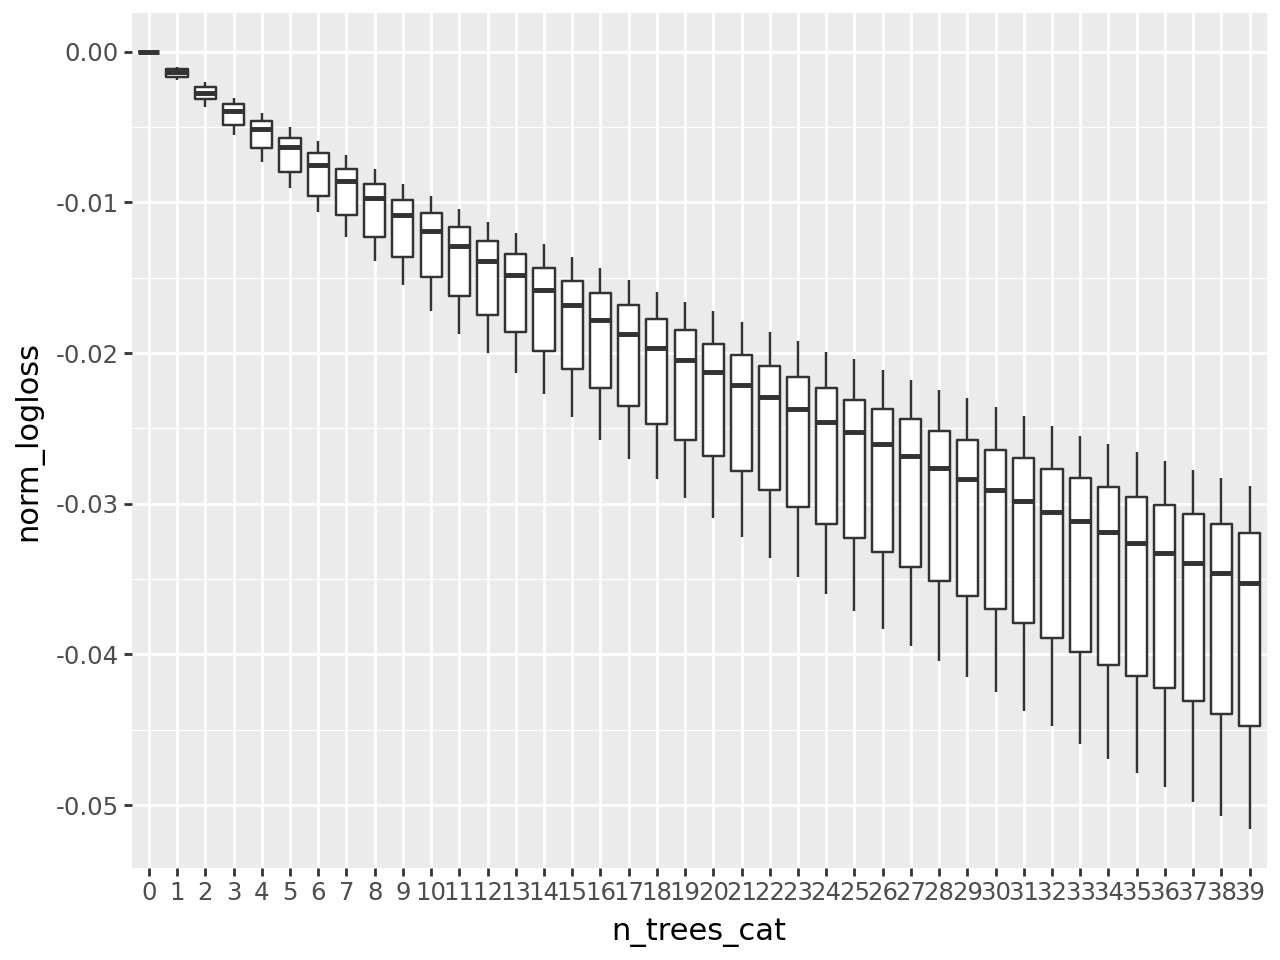

In [33]:
ggplot(train_lc[train_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

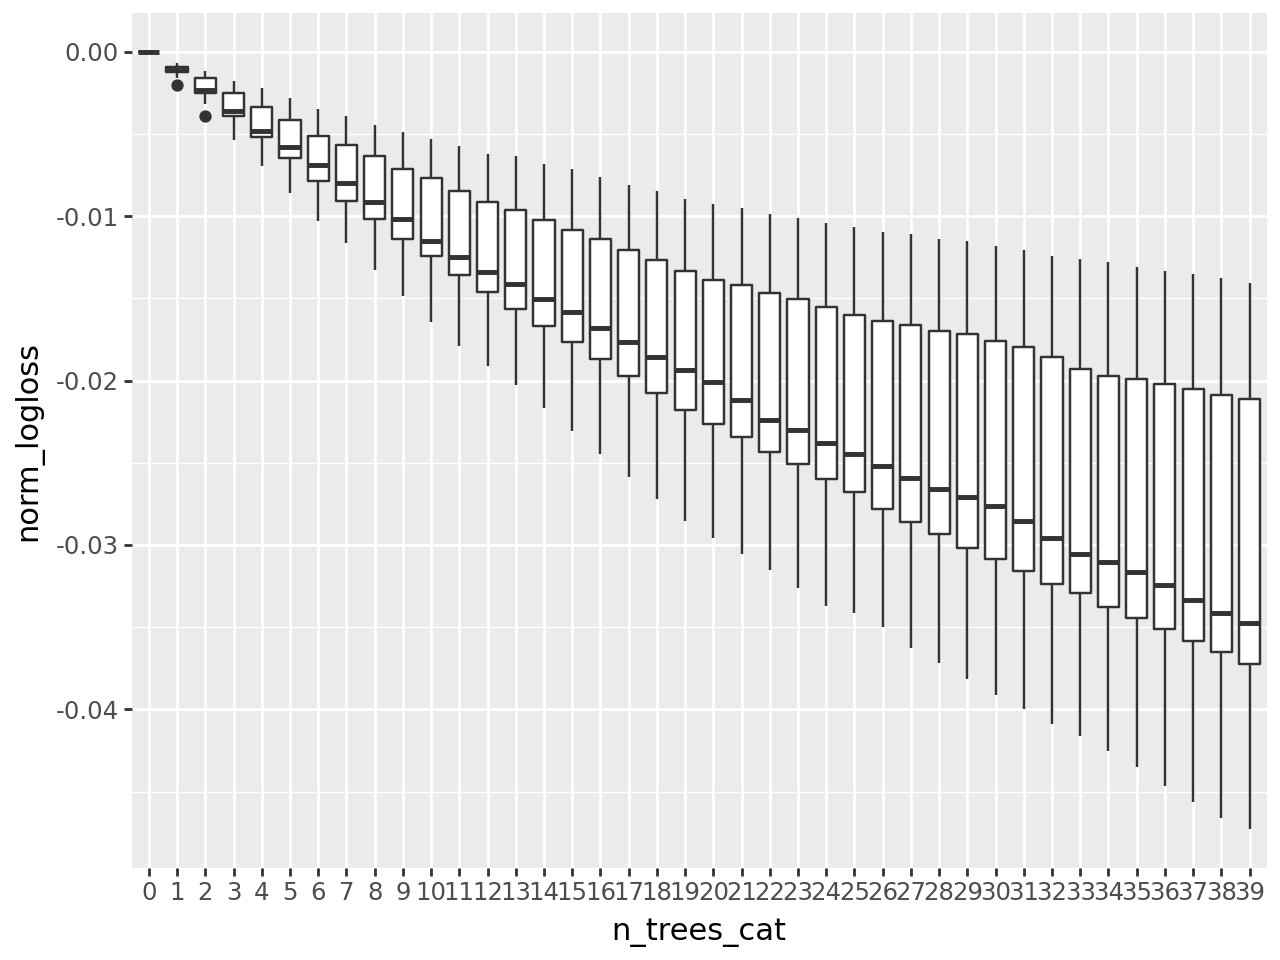

In [34]:
ggplot(test_lc[test_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

In [35]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

filtered_train_lc = train_lc[train_lc["n_trees"] % 10 == 0].copy()
filtered_test_lc = test_lc[test_lc["n_trees"] % 10 == 0].copy()

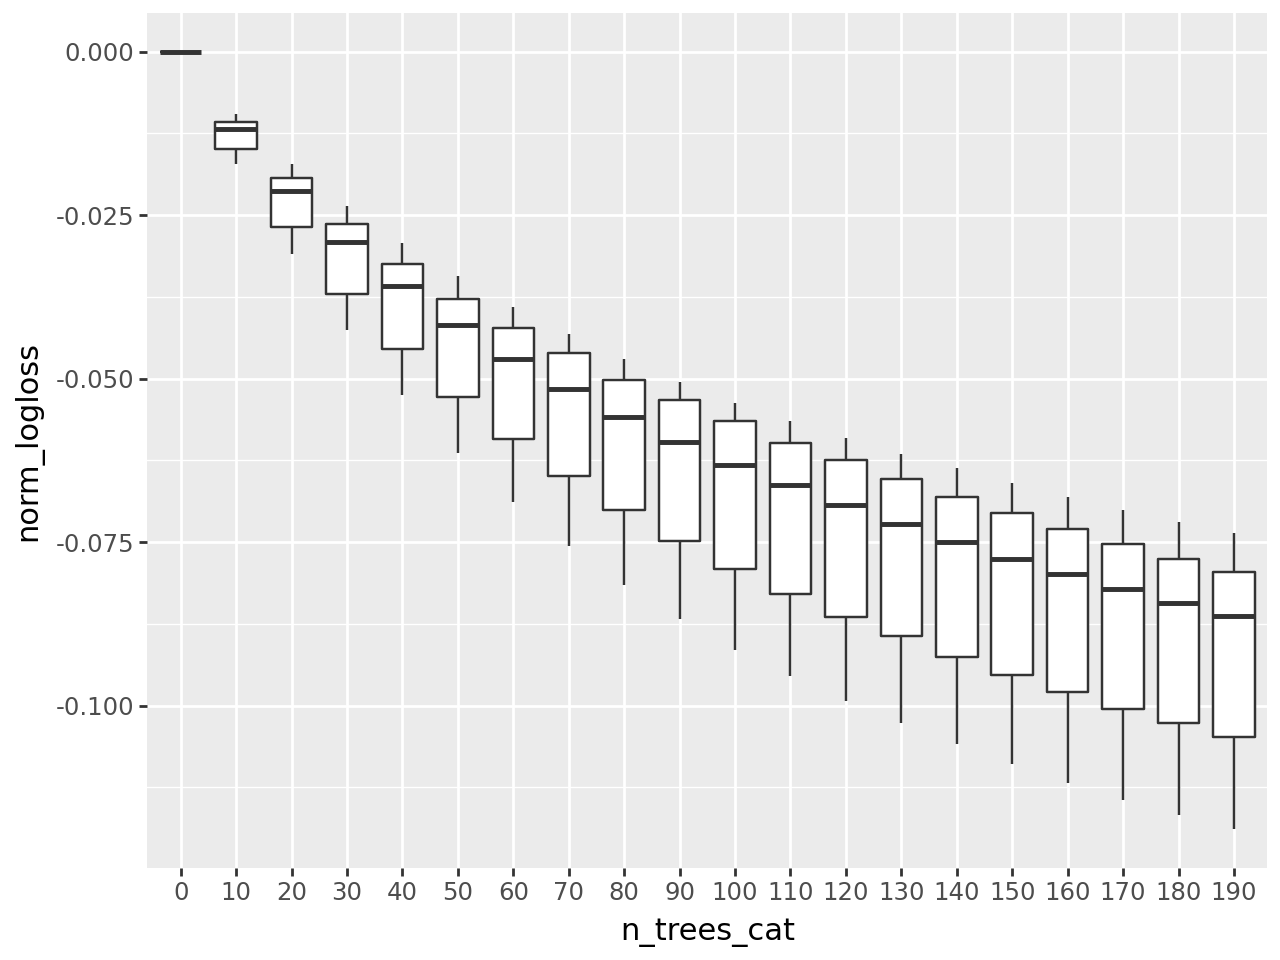

In [36]:
ggplot(filtered_train_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

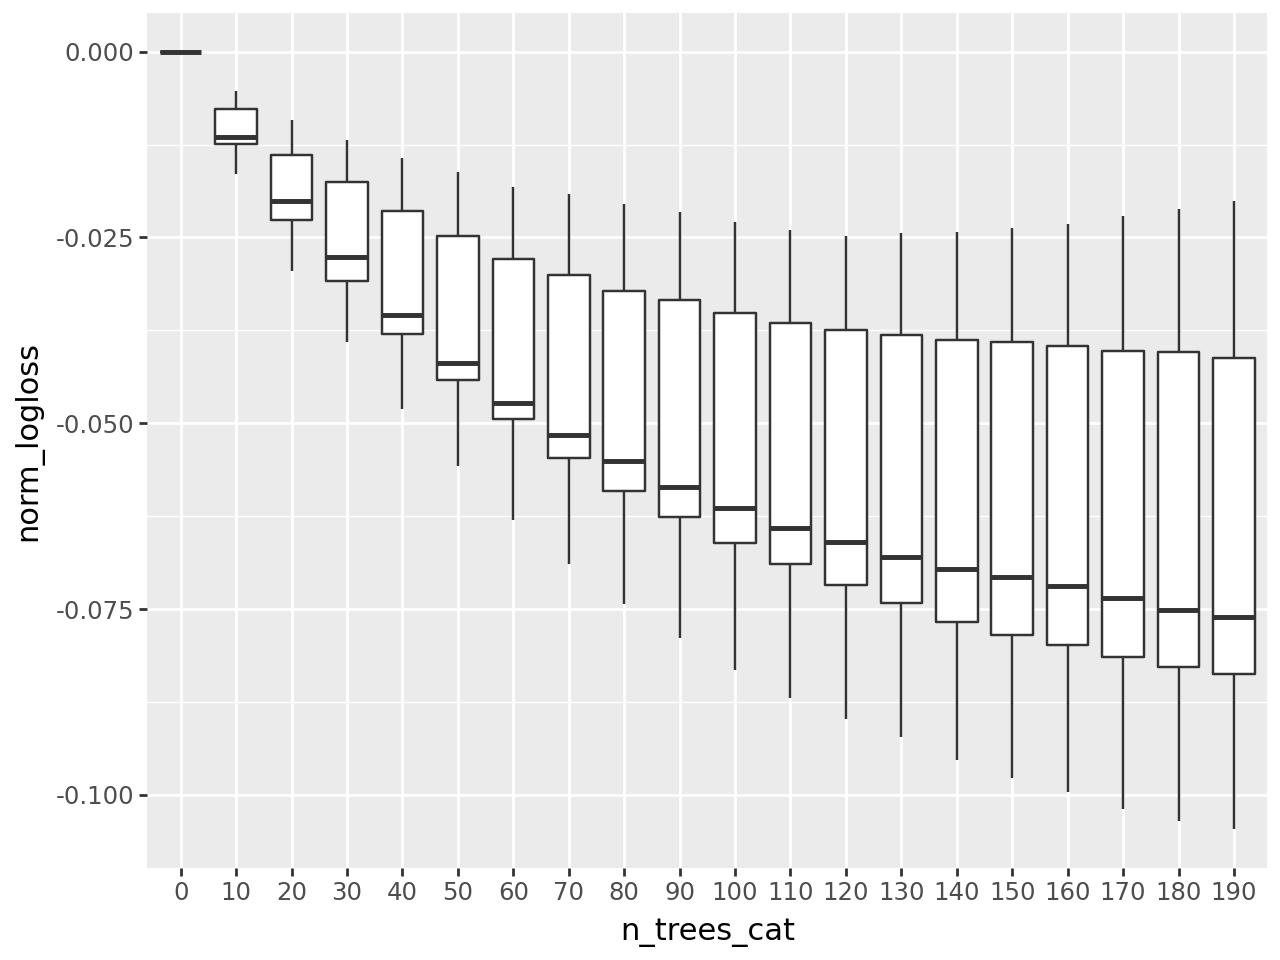

In [37]:
ggplot(filtered_test_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

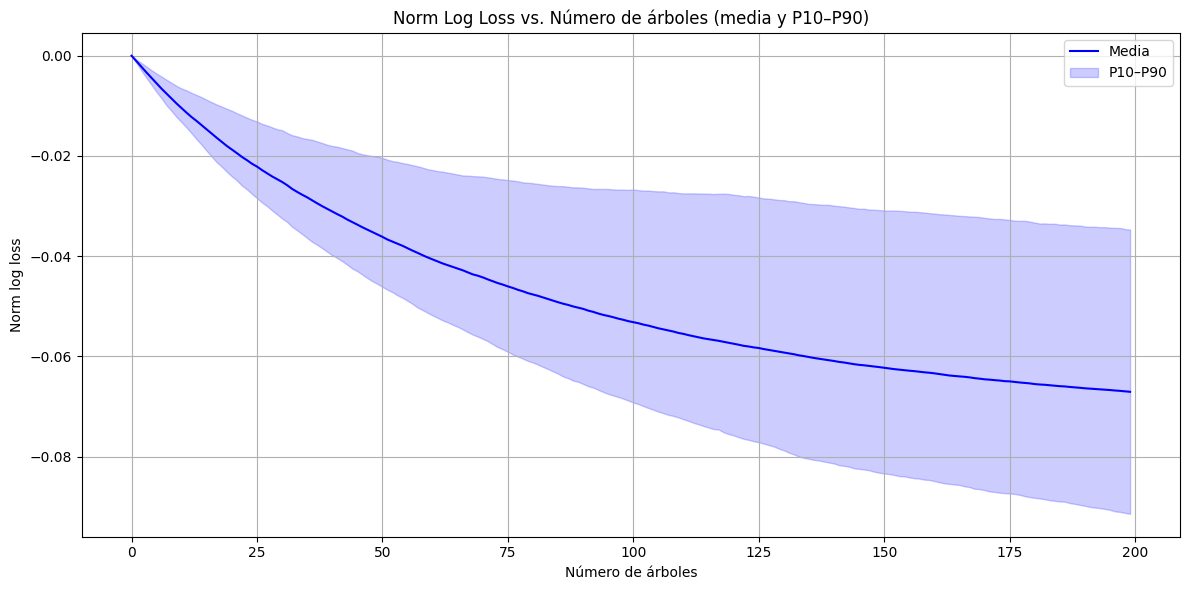

In [38]:
summary = test_lc.groupby("n_trees")["norm_logloss"].agg(
    mean="mean",
    p10=lambda x: x.quantile(0.10),
    p90=lambda x: x.quantile(0.90)
).reset_index()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(summary["n_trees"], summary["mean"], label="Media", color="blue")
plt.fill_between(summary["n_trees"], summary["p10"], summary["p90"], color="blue", alpha=0.2, label="P10–P90")
plt.xlabel("Número de árboles")
plt.ylabel("Norm log loss")
plt.title("Norm Log Loss vs. Número de árboles (media y P10–P90)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
train_lc["set"] = "train"
test_lc["set"] = "test"

data_lc = pd.concat([train_lc, test_lc])

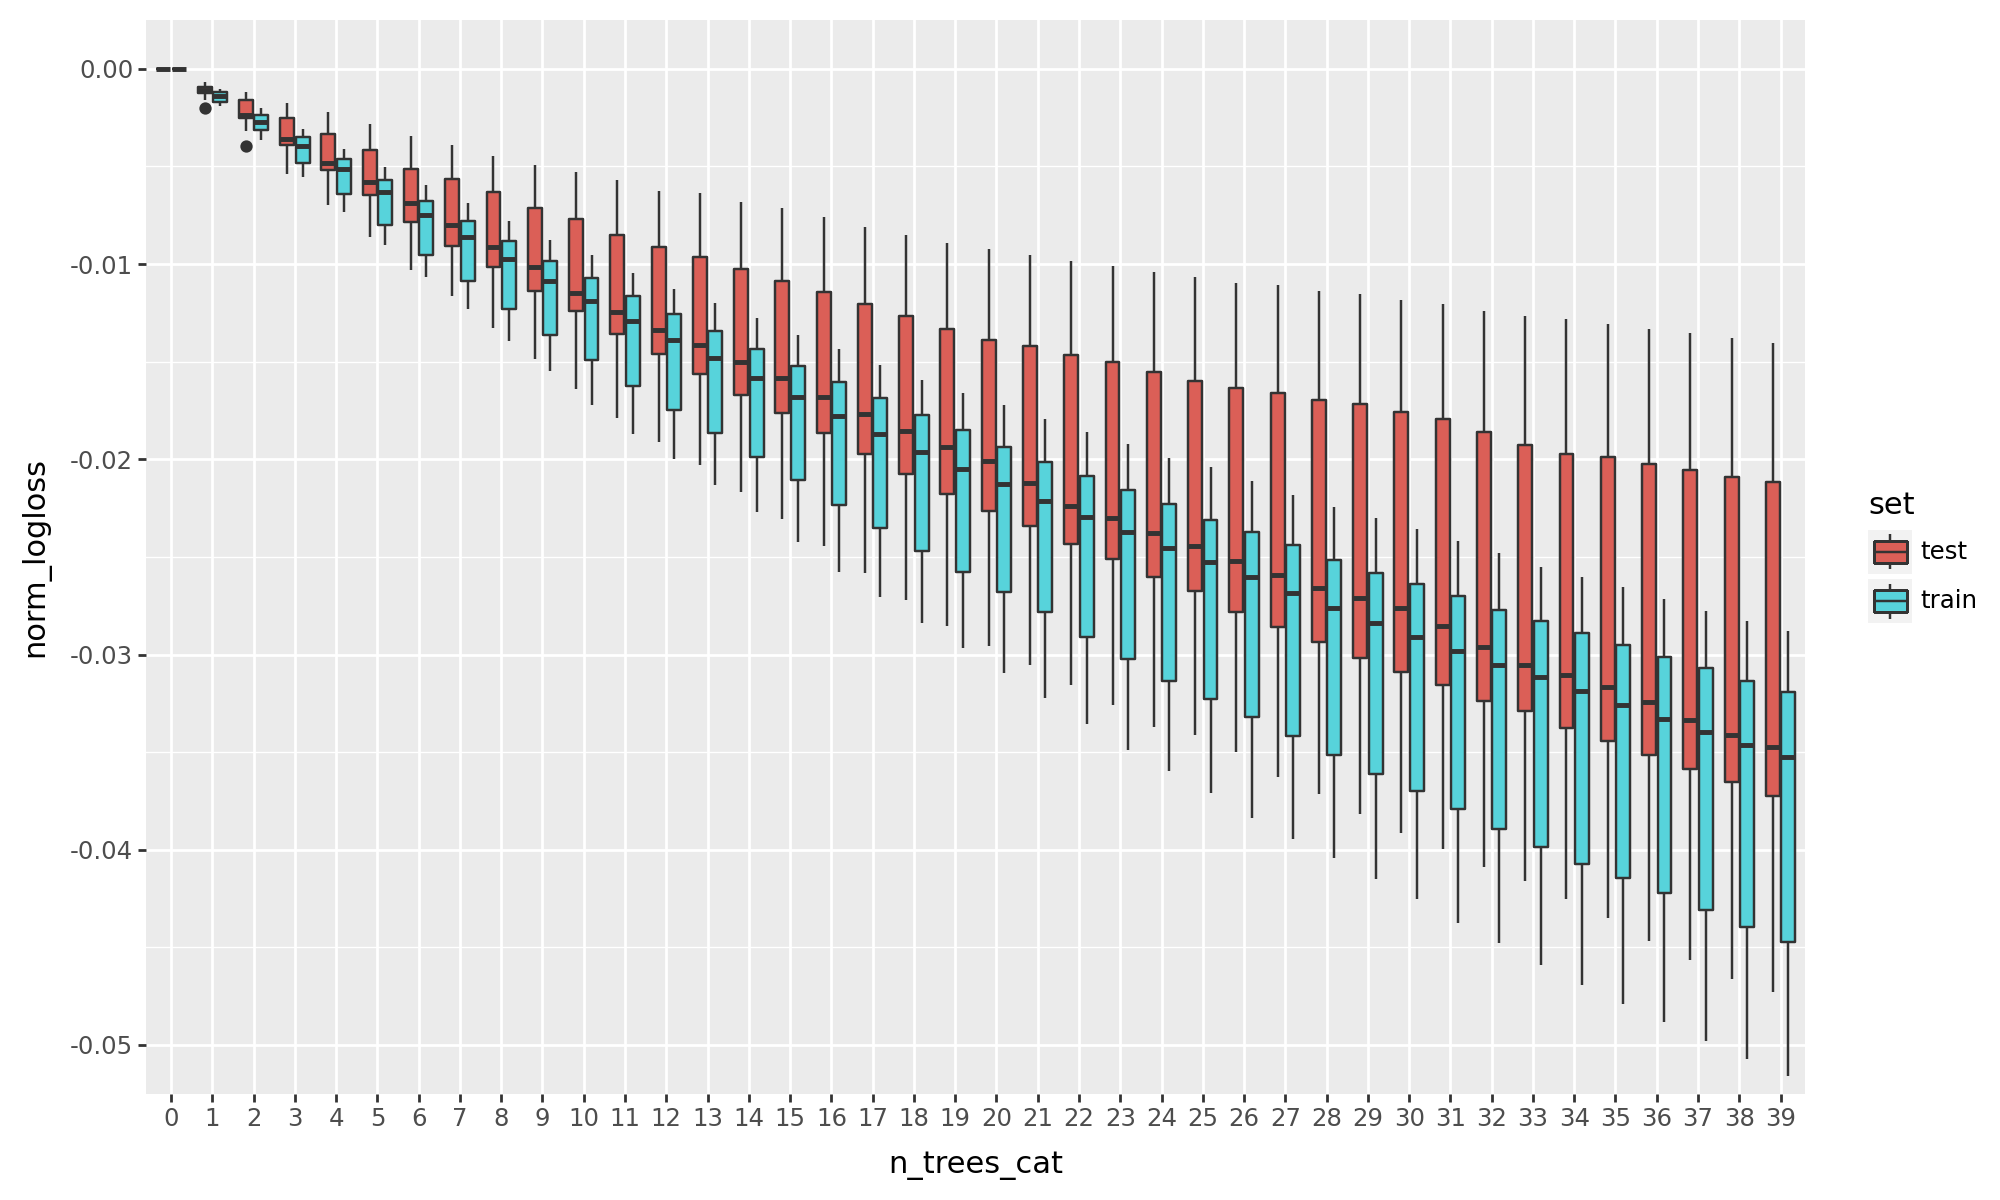

In [40]:
fig = plt.figure(figsize=(10, 6))

ggplot(
    data_lc[data_lc["n_trees"] < 40],
    aes(x="n_trees_cat", y="norm_logloss", fill="set")
) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=(-0.05, 0)) + theme(
    figure_size=(10, 6)
)

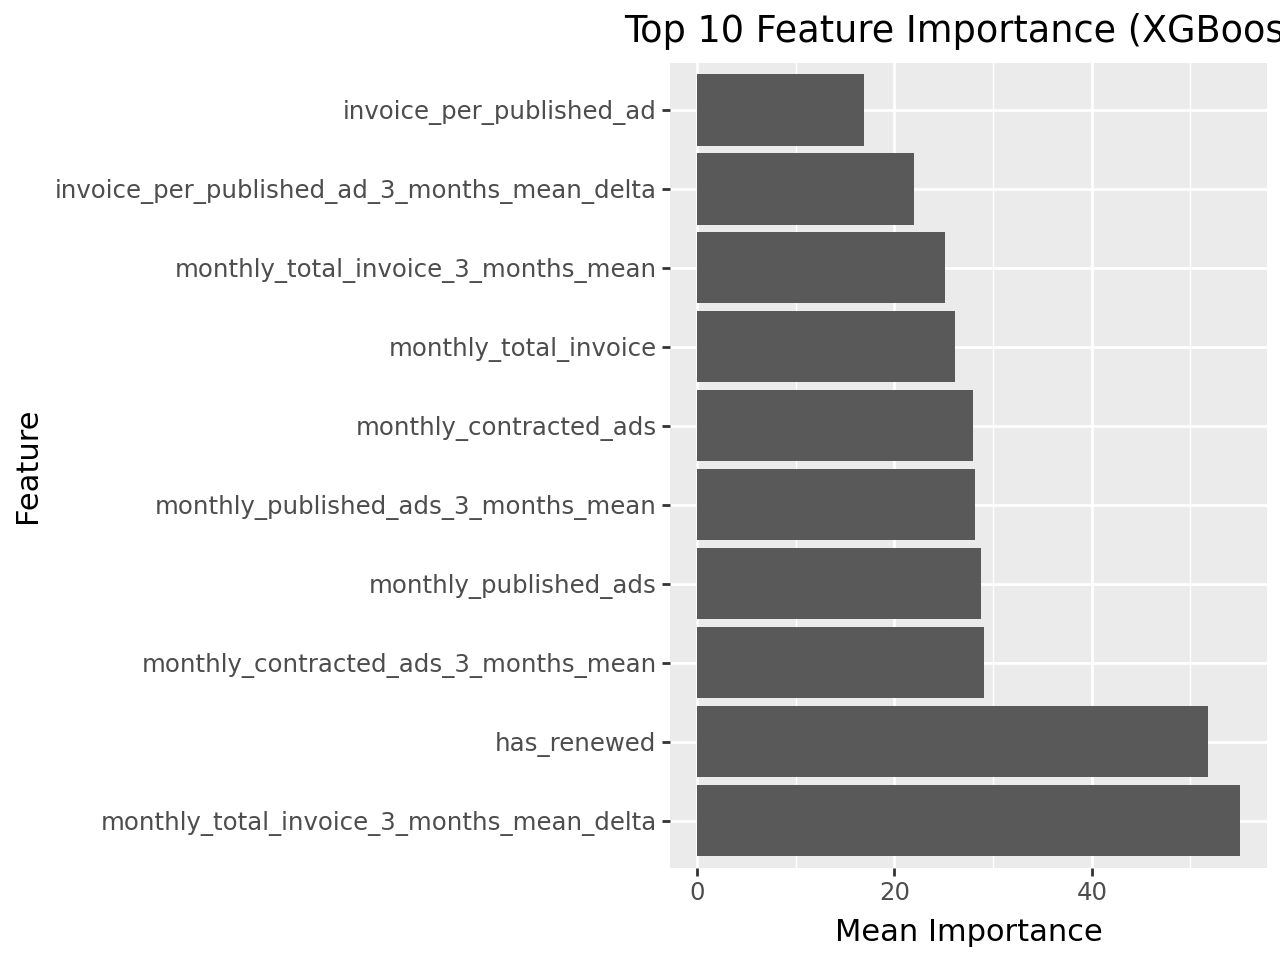

In [41]:
final_importance_df = final_importance_df.sort_values(["execution_date", "importance"], ascending=[False, False])

importance_summary = (
    final_importance_df
    .groupby("feature")["importance"]
    .mean()
    .reset_index()
)

top_features = (
    importance_summary
    .sort_values("importance", ascending=False)
    .head(10)
)

(
    ggplot(top_features) +
    geom_col(aes(x="feature", y="importance")) +
    coord_flip() +
    scale_x_discrete(limits=top_features["feature"].tolist()) +
    labs(title="Top 10 Feature Importance (XGBoost)", x="Feature", y="Mean Importance")
)

# Conclusion

After evaluating feature importance, we proceeded to remove months_since_last_contract due to its disproportionately high influence, followed by tenure which subsequently exhibited similar dominance. While this modification yields more balanced feature importance distributions that align better with our business understanding (now primarily driven by meaningful customer metrics), we observe a significant reduction in model performance - achieving approximately -0.09 log loss in both training and test sets.

The key trade-offs are:

1. The model maintains good generalization, with closely aligned training and validation curves

2. Current feature importance distributions now reflect more logically meaningful customer attributes

3. This comes at the cost of reduced predictive capability

In [42]:
def evaluate_model_on_future_months(
    df: pd.DataFrame,
    training_start_date: datetime.datetime,
    validating_end_date: datetime.datetime,
    n_training_months=6,
    n_estimators: int = 300,
) -> pd.DataFrame:
    validation_months_index = 1
    results = []

    while (
        training_start_date
        + relativedelta(months=n_training_months)
        + relativedelta(months=validation_months_index)
        <= validating_end_date
    ):
        train_set, test_set = split_train_test_by_period(
            df,
            training_start_date,
            n_training_months=n_training_months,
            n_validating_months=validation_months_index,
        )

        train_size, _ = train_set.shape
        test_size, _ = test_set.shape

        if train_size > 0 and test_size > 0:
            _, evals_result, _ = train_model(
                train_set, test_set, n_estimators=n_estimators
            )
            val_month = training_start_date + relativedelta(
                months=n_training_months + validation_months_index - 1
            )
            logloss = evals_result["eval"]["logloss"][-1]
            results.append({"month": val_month, "logloss": logloss})

        validation_months_index += 1

    return pd.DataFrame(results)


In [43]:
training_start_date = datetime.datetime(2023, 3, 1)
validating_end_date = datetime.datetime(2024, 11, 1)

results_df = evaluate_model_on_future_months(
    df,
    training_start_date,
    validating_end_date,
)

<Figure size 1000x600 with 0 Axes>

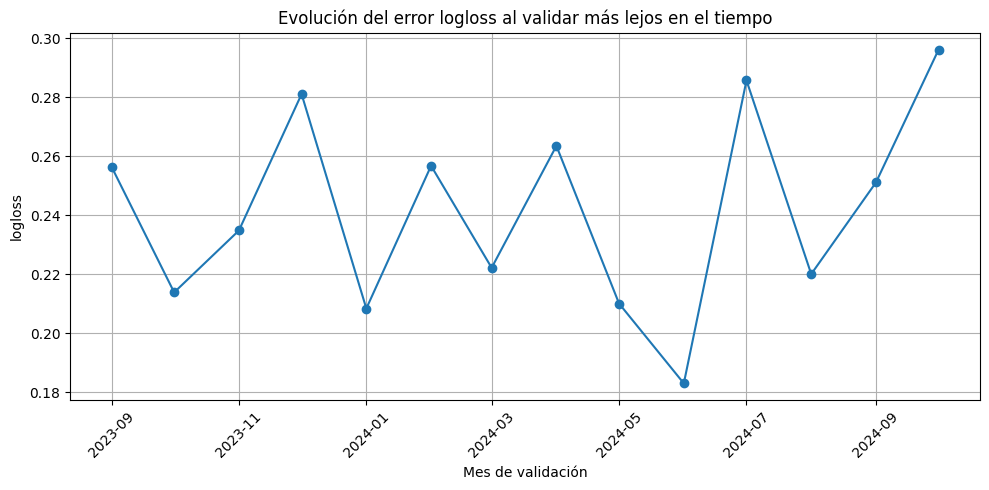

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(results_df["month"], results_df["logloss"], marker="o")
plt.title("Evolución del error logloss al validar más lejos en el tiempo")
plt.xlabel("Mes de validación")
plt.ylabel("logloss")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()